# Bronze Layer Validation — Open Meteo
Validação dos dados brutos coletados da API antes da transformação para a camada Silver.


In [1]:
# Importando bibliotecas principais
import pandas as pd
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Criando a sessão Spark configurada para Delta Lake
builder = SparkSession.builder \
    .appName("BronzeValidation") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()


25/04/14 20:20:22 WARN Utils: Your hostname, obi-wan-kenote resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/14 20:20:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/kenote_ubuntu/projetos/Airflow/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/kenote_ubuntu/.ivy2/cache
The jars for the packages stored in: /home/kenote_ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-13c8ecbc-561e-4c93-ac00-6949ec824f62;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.3.0 in central
	found io.delta#delta-storage;2.3.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
:: resolution report :: resolve 137ms :: artifacts dl 10ms
	:: modules in use:
	io.delta#delta-core_2.12;2.3.0 from central in [default]
	io.delta#delta-storage;2.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3 

25/04/14 20:20:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Definindo o caminho onde os dados foram armazenados em Delta
bronze_path = "/home/kenote_ubuntu/projetos/Airflow/data/bronze/open_meteo"

# Lendo os dados com formato Delta para um DataFrame Spark
df_bronze = spark.read.format("delta").load(bronze_path)



In [4]:
# Conta quantos valores nulos existem em cada coluna
# Isso ajuda a identificar problemas de qualidade dos dados
df_bronze.select([df_bronze[c].isNull().alias(c) for c in df_bronze.columns]) \
    .groupBy().sum().show()


25/04/14 20:20:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


++
||
++
||
++



In [5]:
# Estatísticas descritivas para temperatura mínima e máxima
# Inclui: count, mean, stddev, min, max
df_bronze.describe(["temp_min", "temp_max"]).show()


+-------+------------------+-----------------+
|summary|          temp_min|         temp_max|
+-------+------------------+-----------------+
|  count|               112|              112|
|   mean|17.672321428571426|24.15982142857143|
| stddev| 5.242587385094072|4.515049106742189|
|    min|               8.5|             13.2|
|    max|              26.8|             31.3|
+-------+------------------+-----------------+



In [6]:
df_bronze.describe(["temp_min", "temp_max"]).show()


+-------+------------------+-----------------+
|summary|          temp_min|         temp_max|
+-------+------------------+-----------------+
|  count|               112|              112|
|   mean|17.672321428571426|24.15982142857143|
| stddev| 5.242587385094072|4.515049106742189|
|    min|               8.5|             13.2|
|    max|              26.8|             31.3|
+-------+------------------+-----------------+



/tmp/ipykernel_243124/2546269232.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pd, x="city", y="temp_max", palette="coolwarm")


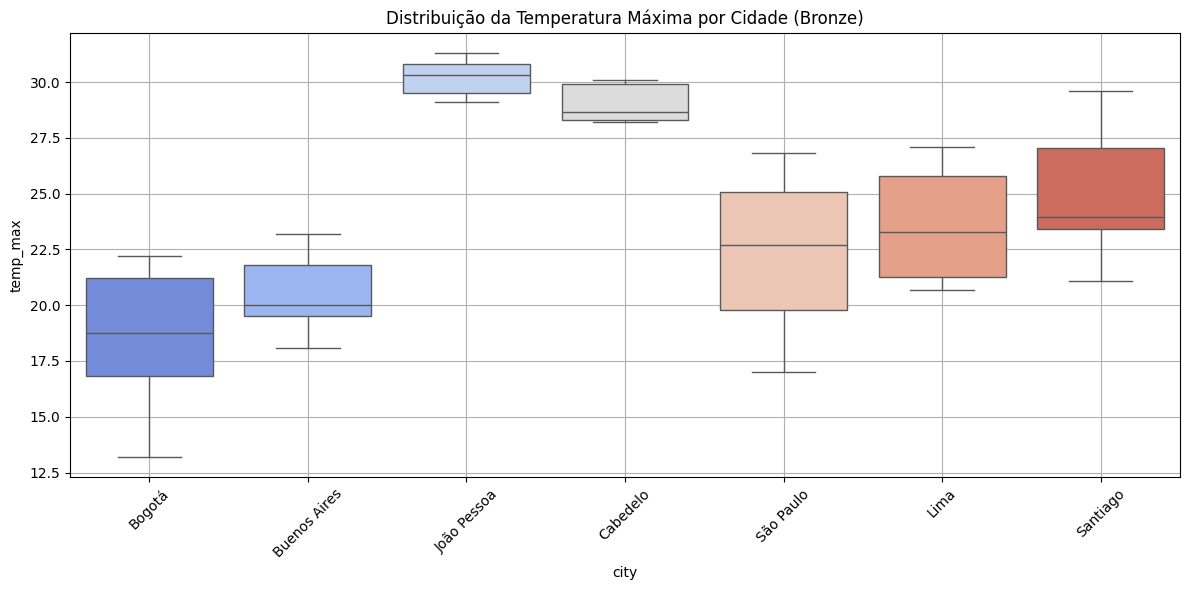

In [7]:
# Convertendo o DataFrame Spark para Pandas para facilitar visualizações com seaborn
df_pd = df_bronze.toPandas()

# Visualizando distribuição da temperatura máxima por cidade com boxplot

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pd, x="city", y="temp_max", palette="coolwarm")
plt.title("Distribuição da Temperatura Máxima por Cidade (Bronze)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Exibe uma amostra dos dados no estilo 'display' do Databricks
# Ajuda na leitura e entendimento das primeiras linhas
from IPython.display import display

display(df_pd.head(10))



,city,date,temp_min,temp_max
0,Bogotá,2025-04-17,11.6,20.6
1,Bogotá,2025-04-18,13.4,21.3
2,Bogotá,2025-04-19,13.1,21.6
3,Bogotá,2025-04-20,13.3,19.3
4,Bogotá,2025-04-21,11.5,19.0
5,Bogotá,2025-04-22,10.6,18.1
6,Bogotá,2025-04-23,11.0,18.0
7,Bogotá,2025-04-24,10.6,16.3
8,Bogotá,2025-04-25,9.8,14.9
9,Bogotá,2025-04-26,9.2,18.5


# Conclusao

🔍 Leitura da Bronze	Confirma que os dados foram salvos corretamente
✅ Validação de schema	Verifica tipos e estrutura
🚨 Verificação de nulos	Identifica problemas antes da Silver
📊 Estatísticas descritivas	Ajuda a detectar outliers ou valores fora do esperado
📈 Visualização	Comunicação clara para quem for usar os dados depois
🧼 Pronto para transformação	A próxima etapa é limpar e transformar → Silver